In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import timeit

### References

Authors who are consistent (10 year career span and atleast 10 papers published) are derived from the notebook 'cumulative-adv-author-statistics-for-analysis'

'authors-scientific-start-end-year.csv' is one of the byproduct of that. But it contains a lot of sparse values, In the sense it contains 
a lot of authors who dropped out early in their career

'authors-scientific-atleast-10-year-10-papers.csv' - contains consistent authors 
Code snippet from 'cumulative-adv-cohort-analysis-for-1970-authors' notebook is heavily used

In [2]:
start_time = timeit.default_timer()
print(start_time)

1.2440019667671095e-06


In [3]:
authorStartEndCareerData = pd.read_csv('data/authors-scientific-start-end-year-publish-count.csv')
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-10-year-10-papers.csv')
#authorStartEndCareerData = pd.read_csv('data/authors-scientific-atleast-20-year-20-papers.csv')
authorStartEndCareerData.head()

,author,start_year,end_year,pub_count
0,'maseka lesaoana,2001,2015,2
1,(max) zong-ming cheng,2009,2011,2
2,(zhou) bryan bai,2011,2012,2
3,a lun,2010,2010,1
4,a min tjoa,1979,2015,193


In [4]:
groupByStartYearScientificCareerData = authorStartEndCareerData[['author','start_year']].groupby(['start_year'])
groupByStartYearScientificCareerData.groups

{1970: Int64Index([     55,     148,    1164,    1490,    2245,    2250,    2420,
                2525,    3040,    3250,
             ...
             1637528, 1654954, 1656355, 1657684, 1668510, 1668929, 1685326,
             1703339, 1704543, 1706204],
            dtype='int64', length=1835),
 1971: Int64Index([    218,     441,    1482,    1663,    2556,    2566,    2891,
                3025,    3280,    3528,
             ...
             1685941, 1685958, 1686039, 1686187, 1687109, 1687576, 1703548,
             1703680, 1706128, 1706976],
            dtype='int64', length=2092),
 1972: Int64Index([    288,     333,     337,    1398,    1542,    1884,    2213,
                2399,    2405,    2597,
             ...
             1675205, 1675437, 1679767, 1681701, 1683153, 1683204, 1683442,
             1686076, 1686169, 1701471],
            dtype='int64', length=1982),
 1973: Int64Index([    176,     439,    1184,    1596,    1665,    2120,    2130,
                2232,    25

In [5]:
authorPublicationsData = pd.read_csv('data/author_publications_1970_2016_asiansAsNone.txt')
# To speed up the implementation, if required consider a small dataset
# Look at 'shorten-dblp-data-for-faster-access' notebook to creat a smaller dataset
#authorPublicationsData = pd.read_csv('data/author_publications_1970_2000_asiansAsNone.csv')
authorPublicationsData.head()

,author,year,pub_id
0,kim l. blackwell,2014,55503da645ce0a409eb273e8
1,nima mesgarani,2014,55503da645ce0a409eb273e9
2,james j. abbas,2014,55503da645ce0a409eb273ea
3,eberhart zrenner,2014,55503da645ce0a409eb273ec
4,jonathan rubin,2014,55503da645ce0a409eb273e0


In [6]:
#get the year list - as it helps to enumerate and find gini co-efficient for each year (irrespective of the dataset)
years = np.sort(authorPublicationsData['year'].unique())
print(years)

[1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984
 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999
 2000 2001 2002 2003 2004 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014
 2015 2016]


In [7]:
#Group by both year and author - multi index and hierarchial indexing
groupByAuthorYear = authorPublicationsData.groupby(['year','author'])
# count of no. of publications for each and every author for every year
groupByAuthorYearData = groupByAuthorYear.count() 

In [8]:
#the following snippet is taken from the github project and the license is creative commons
#https://github.com/oliviaguest/gini

def gini(array):
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    # All values are treated equally, arrays must be 1d:
    array = array.flatten()
    if np.min(array) < 0:
        # Values cannot be negative:
        array -= np.min(array)
    # Values cannot be 0:
    array += 0.0000001
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))

### To check whether GINI calculation works correctly or not

Gini value -  0.194337310743


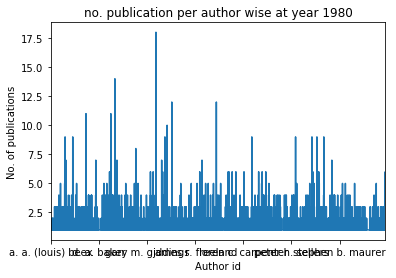

In [9]:
temp = groupByAuthorYearData.loc[1980]
noOfAuthorsWhoPublishedNothing = temp.isnull().sum()['pub_id'] / temp.size

# fill 0 for authors who has not published and change the data to float for gini function (relevant to implementaion) to work
temp.fillna(value=0, inplace=True)
#temp = temp['pub_id'].values
#groupByAuthorYearData.loc[i]['pub_id'].as_matrix()
temp = temp.astype(float)
print('Gini value - ', gini(temp['pub_id'].values))
ax = temp.plot(title='no. publication per author wise at year 1980', 
                         legend=False)
ax.set_xlabel("Author id")
ax.set_ylabel("No. of publications")
plt.show()

In [10]:
gini_evolution = pd.DataFrame(index=years)
non_publishers_track = pd.DataFrame(index=years)
for year in groupByStartYearScientificCareerData.indices:
    authors_for_comparison = groupByStartYearScientificCareerData.get_group(year)
    gini_over_years = pd.Series(data=0, index=years)
    non_publishers_over_years = pd.Series(data=0, index=years)
    for i in range(year, max(years)+1):
        # get all the authors data for each year and filter based on the authors that we are interested in
        temp = groupByAuthorYearData.loc[i]
        temp = temp.loc[authors_for_comparison['author']]
        noOfAuthorsWhoPublishedNothing = temp.isnull().sum()['pub_id'] / temp.size

        # fill 0 for authors who has not published and change the data to float for gini function (relevant to implementaion) to work
        temp.fillna(value=0, inplace=True)
        #temp = temp['pub_id'].values
        #groupByAuthorYearData.loc[i]['pub_id'].as_matrix()
        temp = temp.astype(float)
        gini_over_years.loc[i] = gini(temp['pub_id'].values)
        non_publishers_over_years.loc[i] = noOfAuthorsWhoPublishedNothing
         
    gini_evolution[year] = gini_over_years
    non_publishers_track[year] = non_publishers_over_years
#print(year)
#print(gini_evolution[year])
#break

In [11]:
#authors_for_comparison.describe()

#scientificYearStartHistogram = temp['pub_id'].value_counts(sort=False)
#ax = scientificYearStartHistogram.sort_index().plot(kind='bar', title='Start of Scientific career histogram')
#ax.set_xlabel("Year")
#ax.set_ylabel("No. of authors who published first time")
#plt.show()

#scientificYearStartHistogram.describe()

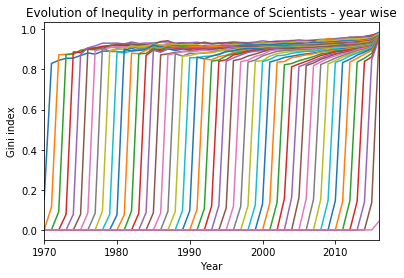

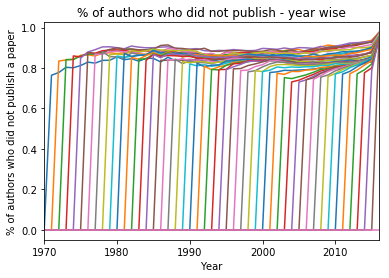

In [12]:
ax = gini_evolution.plot(title='Evolution of Inequlity in performance of Scientists - year wise', 
                         legend=False)
ax.set_xlabel("Year")
ax.set_ylabel("Gini index")
plt.show()


ax = non_publishers_track.plot(title='% of authors who did not publish - year wise',
                              legend=False)
ax.set_xlabel("Year")
ax.set_ylabel("% of authors who did not publish a paper")
plt.show()

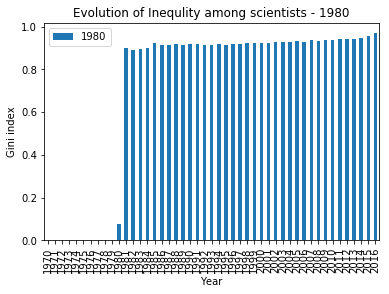

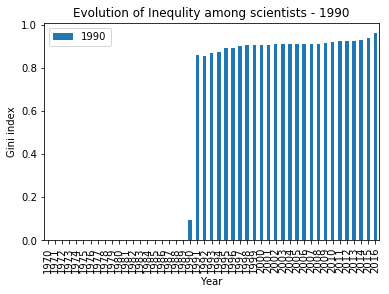

In [13]:
ax = gini_evolution[[1980]].plot(kind='bar', title='Evolution of Inequlity among scientists - 1980')
#ax.plot(non_publishers_track[1990])
ax.set_xlabel("Year")
ax.set_ylabel("Gini index")
plt.show()

ax = gini_evolution[[1990]].plot(kind='bar', title='Evolution of Inequlity among scientists - 1990')
#ax.plot(non_publishers_track[1990])
ax.set_xlabel("Year")
ax.set_ylabel("Gini index")
plt.show()

In [14]:
list(range(1970,1980,2))

[1970, 1972, 1974, 1976, 1978]

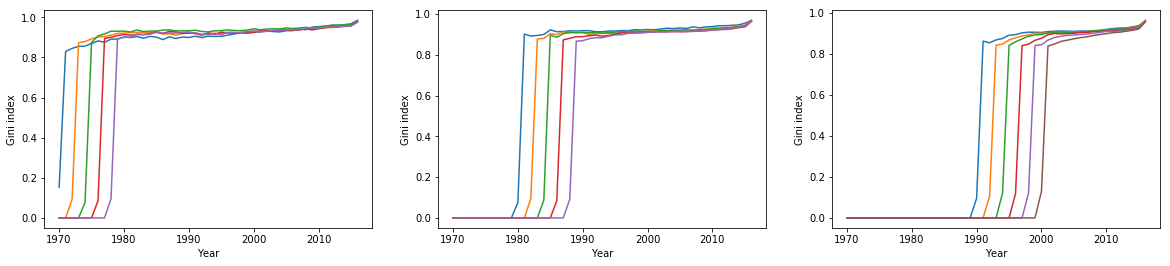

In [15]:
f1 = plt.figure(1,figsize=(20,4))
s1 = f1.add_subplot(131)
ax1 = s1.axes
ax1.set_xlabel("Year")
ax1.set_ylabel("Gini index")
s1.plot(gini_evolution[list(range(1970,1980,2))])
#ax1 = gini_evolution[list(range(1970,1980,2))].plot(title='Evolution of Inequlity among scientists - in 1970s')
#ax.plot(non_publishers_track[1990])

s2 = f1.add_subplot(132)
s2.plot(gini_evolution[list(range(1980,1990,2))])
ax2 = s2.axes
#ax2 = gini_evolution[list(range(1980,1990,2))].plot(title='Evolution of Inequlity among scientists - in 1980s')
#ax.plot(non_publishers_track[1990])
ax2.set_xlabel("Year")
ax2.set_ylabel("Gini index")


s3 = f1.add_subplot(133)
s3.plot(gini_evolution[list(range(1990,2002,2))])
ax3 = s3.axes
#ax2 = gini_evolution[list(range(1980,1990,2))].plot(title='Evolution of Inequlity among scientists - in 1990s')
#ax.plot(non_publishers_track[1990])
ax3.set_xlabel("Year")
ax3.set_ylabel("Gini index")

plt.show()

In [16]:
end_time = timeit.default_timer()
print(end_time)
print('Time taken - ',end_time-start_time)

120.79889899605931
Time taken -  120.79889775205734
